# MedICSS 2021

In [1]:
from dateutil import rrule
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn import metrics, model_selection, preprocessing, pipeline

# Required if running on Google Colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !git clone https://www.github.com/ucl-pond/tadpole-medicss.git
    pth_to_add = '/content/tadpole-medicss/pages/notebooks/modelling'
    import sys
    sys.path.insert(0,pth_to_add)

import tadpole_metrics

%matplotlib inline
pd.set_option('display.max_columns', None)

# Load Training, Forecast, and Test datasets

## `D1`: TADPOLE Training set

This training dataset contains medical data including:
* MRI scans
* PET scans
* DTI scans
* Cognitive assessment data
* Demographic data
* Genetic data
* CSF data

## `D2`/`D3`: TADPOLE Prediction/Forecast sets (longitudinal/cross-sectional)

These are subsets of `D1`; the list of candidate "rollover" subjects for whom to generate forecasts

## `D4`: TADPOLE Test data (future visits from Prediction/Forecast sets)

The future data to be predicted/forecast.

See the [background information](https://ucl-pond.github.io/tadpole-medicss/pages/description/project.html) and [TADPOLE website](https://tadpole.grand-challenge.org/data/) for more information on the TADPOLE datasets.



<hr/>

Earlier versions of this project occurred before `D4` existsed, and so they used the so-called "Leaderboard" datasets generated from `D1` and `D2`:

## LB1: TADPOLE Standard training set.

This training dataset contains medical data including:
* MRI scans
* PET scans
* DTI scans
* Cognitive assessment data
* Demographic data
* Genetic data
* CSF data

## LB2: TADPOLE Standard prediction set.

This is a subset of LB1; the list of subjects to be predicted in the final submission

If you haven't generated the Leaderboard datasets yet, run the following (code available from the [TADPOLE repo](https://github.com/noxtoby/TADPOLE)):

```ruby
from makeLeaderboardDataset import *
import pandas as pd

generateLBdatasets(inputFolder='../data/', outputFolder='../data/')
```

In [19]:
# Load TADPOLE data
DATA_DIR = Path('../data')
# tadpole = pd.read_csv(DATA_DIR / 'TADPOLE_LB1_LB2.csv', low_memory=False)
tadpole = pd.read_csv(DATA_DIR / 'TADPOLE_D1_D2.csv', low_memory=False)
tadpole_test = pd.read_csv(DATA_DIR / 'TADPOLE_D4_corr.csv', low_memory=False)

#tadpole.head()

# Choose variables of interest

In [20]:
# Convert the variable DX to three categories only (MCI, AD, CN) and save it to 'diagnosis'
dx_map = {
        'MCI': 'MCI',
        'NL': 'CN',
        'Dementia': 'AD',
        'MCI to Dementia': 'AD',
        'NL to MCI': 'MCI',
        'MCI to NL': 'CN',
        'Dementia to MCI': 'MCI',
        'NL to Dementia': 'AD'
    }
tadpole['diagnosis'] = tadpole['DX'].map(dx_map)

In [21]:
y_num_cols = ["ADAS13", "Ventricles"]
y_cat_cols = ["diagnosis"]

outcomes = ["ADAS13", "diagnosis", "Ventricles"]
cog_tests_attributes = ["CDRSB", "ADAS11", "MMSE", "RAVLT_immediate"]
mri_measures = ['Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp' , "FDG", "AV45"]
pet_measures = ["FDG", "AV45"]
csf_measures = ["ABETA_UPENNBIOMK9_04_19_17", "TAU_UPENNBIOMK9_04_19_17", "PTAU_UPENNBIOMK9_04_19_17"]
risk_factors = ["APOE4", "AGE"]

In [22]:
useful_numerical_attribs = cog_tests_attributes + mri_measures + pet_measures + csf_measures + ['AGE']
useful_categorical_attribs = ['RID', 'SITE', 'DXCHANGE', 'PTGENDER',
       'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']

In [23]:
def convert_float(val):
    try:
        return float(val)
    except ValueError:
        return np.nan

In [24]:
for col in csf_measures:
    tadpole[col] = tadpole[col].map(lambda x:convert_float(x))

In [25]:
tadpole[useful_categorical_attribs] = tadpole[useful_categorical_attribs].astype(str)

In [26]:
tadpole.shape

(12741, 1908)

# Data cleaning

In this section we will reduce the dataset from $>1900$ features to the $20$ of interest that we have selected in the section above

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

In [28]:
class LabelBinarizerPipelineFriendly(LabelBinarizer):

    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)



In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [30]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(useful_numerical_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
#     ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(['APOE4'])),
    ('label_binarizer', LabelBinarizerPipelineFriendly()),
])

In [31]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [44]:
tadpole_prepared = full_pipeline.fit_transform(tadpole)

In [33]:
tadpole_prepared.shape

(12741, 20)

### Visualise the data


In [ ]:
# Add age at exam
tadpole.EXAMDATE = pd.to_datetime(tadpole.EXAMDATE)
tadpole_grouped = tadpole.groupby("RID").apply(lambda x:(x["EXAMDATE"]-x["EXAMDATE"].min()).dt.days/365.25 + x["AGE"].min())
tadpole_grouped.sort_index(inplace=True)
tadpole.sort_values(by=["RID", "EXAMDATE"], inplace=True)
tadpole["AGE_AT_EXAM"] = tadpole_grouped.values
tadpole['AGE_INT'] = tadpole['AGE_AT_EXAM'].apply(int)

In [ ]:
tadpole[tadpole['ADAS13'].notnull()]\
    .groupby('AGE_INT')['ADAS13']\
    .count().plot()

In [ ]:
tadpole[tadpole['ADAS13'].notnull()]\
    .groupby('diagnosis')['ADAS13']\
    .mean().plot()

In [ ]:
tadpole[tadpole['Ventricles'].notnull()]\
    .groupby('diagnosis')['Ventricles']\
    .mean().plot()

In [ ]:
tadpole[tadpole['Ventricles'].notnull()]\
    .groupby('AGE_INT')['Ventricles']\
    .mean().plot()

In [ ]:
# Other ways of visualising the data

# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Create a visualization
sns.relplot(
    data=tadpole,
    x="AGE_INT", y="ADAS13",
    hue="diagnosis", style="diagnosis"
)

## Split the dataset into train and test

Perform stratified shuffle split of data  (to avoid over sampling on marital status, ethinicity or gender)

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index \
in split.split(tadpole_prepared, tadpole[["PTMARRY", "PTGENDER","PTETHCAT"]]):
    strat_train_set = tadpole.loc[train_index]
    strat_test_set = tadpole.loc[test_index]

In [40]:
# # WIP/FIXME. Make this work below: full_pipeline.fit_transform(strat_test_set)
# train_index = (tadpole[['D1','D2']]==1).all(axis=1).values
# test_index  = (tadpole_test['LB4']==1).values
# strat_train_set = tadpole.loc[train_index]
# strat_test_set  = tadpole_test.loc[test_index]

In [47]:
tadpole_prepared_train = full_pipeline.fit_transform(strat_train_set)

In [48]:
tadpole_prepared_test = full_pipeline.fit_transform(strat_test_set)

In [49]:
tadpole_prepared_train.shape 

(10192, 20)

## Impute Missing Data

Now that we have our reduced dataset, let's impute the numerical and categorical features separately. 

We can use different strategies, two of the most common ones to use are: Mean and Most frequent.

Remember! In order to avoid data leakage from the train to the test data, the imputer is tested only in the training dataset! 

In [50]:
from sklearn.impute import SimpleImputer

#Impute numerical variables with the mean value 
imputer = SimpleImputer(strategy="mean")
imputer.fit(strat_train_set[y_num_cols])

y_num_train_imp = imputer.transform(strat_train_set[y_num_cols])
y_num_test_imp = imputer.transform(strat_test_set[y_num_cols])

#Impute categorical values 
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit(strat_train_set[y_cat_cols])

y_cat_train_imp = imputer_cat.transform(strat_train_set[y_cat_cols])
y_cat_test_imp = imputer_cat.transform(strat_test_set[y_cat_cols])


# Linear Regression 

## Predicting ADAS13

In [51]:
tadpole_labels_train = y_num_train_imp[:,0] #ADAS13

In [52]:
from sklearn.linear_model import LinearRegression 

lin_reg = LinearRegression() 

#Fit model on the training set that we have prepared (with 20 variables) and the variable that we want to predict 
lin_reg.fit(tadpole_prepared_train, tadpole_labels_train)

#Predict on testing set
tadpole_predictions = lin_reg.predict(tadpole_prepared_test)

In [53]:
from sklearn.metrics import mean_absolute_error

tadpole_labels_test = y_num_test_imp[:,0] #ADAS13
mae_Adas13 = mean_absolute_error(tadpole_predictions, tadpole_labels_test)

In [54]:
mae_Adas13

1.7997169729028715

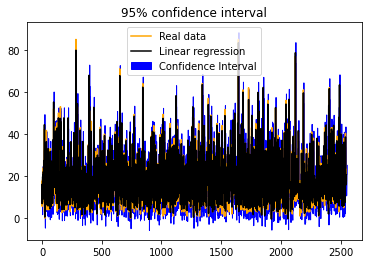

In [55]:
#Code from https://github.com/morallito/medium_ds_series/blob/main/%5BDS0001%5D/main.py#L7
from scipy import stats

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    INPUTS:
    - Single prediction,
    - y_test
    - All test set predictions,
    - Prediction interval threshold (default = .95)
    OUTPUT:
    - Prediction interval for single prediction
    '''
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    #generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper


## Plot and save confidence interval of linear regression  - 95% cs_24
lower_vet = []
upper_vet = []

for i in tadpole_predictions:
    lower, prediction, upper =  get_prediction_interval(i, tadpole_labels_test, tadpole_predictions)
    lower_vet.append(lower)
    upper_vet.append(upper)

plt.fill_between(np.arange(0,len(tadpole_labels_test),1),upper_vet, lower_vet, color='b',label='Confidence Interval')
plt.plot(np.arange(0,len(tadpole_labels_test),1),tadpole_labels_test,color='orange',label='Real data')
plt.plot(tadpole_predictions,'k',label='Linear regression')
plt.title('95% confidence interval')
plt.legend()
plt.show()

## Predicting Ventricles size

In [56]:
tadpole_labels_train = y_num_train_imp[:,1] #ADAS13
lin_reg = LinearRegression() 

#Fit model on training set
lin_reg.fit(tadpole_prepared_train, tadpole_labels_train)

#Predict on testing set
tadpole_predictions = lin_reg.predict(tadpole_prepared_test)

#Error metric
tadpole_labels_test = y_num_test_imp[:,1] 
mae_vent = mean_absolute_error(tadpole_predictions, tadpole_labels_test)

In [57]:
mae_vent

10381.745336613489

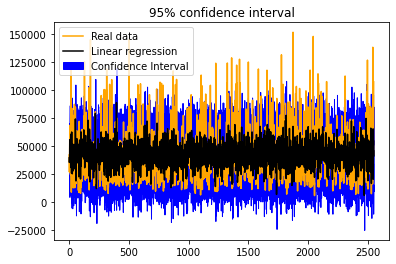

In [58]:
## Plot and save confidence interval of linear regression  - 95% cs_24
lower_vet = []
upper_vet = []

for i in tadpole_predictions:
    lower, prediction, upper =  get_prediction_interval(i, tadpole_labels_test, tadpole_predictions)
    lower_vet.append(lower)
    upper_vet.append(upper)

plt.fill_between(np.arange(0,len(tadpole_labels_test),1),upper_vet, lower_vet, color='b',label='Confidence Interval')
plt.plot(np.arange(0,len(tadpole_labels_test),1),tadpole_labels_test,color='orange',label='Real data')
plt.plot(tadpole_predictions,'k',label='Linear regression')
plt.title('95% confidence interval')
plt.legend()
plt.show()

# Random Forests

In [59]:
#Choose variable - diagnosi

tadpole_labels_train = y_cat_train_imp

In [60]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets 
clf.fit(tadpole_prepared_train, tadpole_labels_train.ravel())

# Test 
y_pred=clf.predict(tadpole_prepared_test)

In [61]:
# View accuracy score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
tadpole_labels_test = y_cat_test_imp
accuracy_score(tadpole_labels_test, y_pred)

0.9129070223617105

In [62]:
# View confusion matrix for test data and predictions
confusion_matrix(tadpole_labels_test, y_pred)

array([[ 341,    0,   70],
       [   0,  485,   74],
       [  40,   38, 1501]])

In [63]:
df = pd.DataFrame(y_cat_train_imp)
df.value_counts()

MCI    6310
CN     2186
AD     1696
dtype: int64

In [64]:
# View the classification report for test data and predictions
print(classification_report(tadpole_labels_test, y_pred))

              precision    recall  f1-score   support

          AD       0.90      0.83      0.86       411
          CN       0.93      0.87      0.90       559
         MCI       0.91      0.95      0.93      1579

    accuracy                           0.91      2549
   macro avg       0.91      0.88      0.90      2549
weighted avg       0.91      0.91      0.91      2549

